Esse notebook irá explorar o t2 calculado a partir dos arquivos gerados na simulação two_peaks_noisy


In [1]:
from commpy.channels import awgn
import numpy as np
import matplotlib.pyplot as plt
import pyMRI.pymri as pymri
import pandas as pd
from pyMRI.utils import RMSE
import seaborn as sns
from typing import Literal

In [2]:
metabolites = pymri.METABOLITES
met_i = 1

t0, tn, dt, B0 = pymri.setup_sim_t(0.0, 1.0, 2048, 3.0)

ws, t2s, M_0s = pymri.unpack_metabolites(metabolites, B0)
ws, t2s, M_0s = ws[met_i - 1:met_i + 1], t2s[met_i - 1:met_i + 1], M_0s[met_i - 1:met_i + 1]
spins_phi = np.zeros_like(M_0s)
ws[0] = ws[1]
t2s[0] = t2s[1]
M_0s[0] = M_0s[1]

rcond = 1e-7 
zero_filtering = 1e-14

print( "All frequencies are captured by the sampling rate." if pymri.check_frequency(ws, dt) == True 
      else f"At least one frequency is NOT captured by the sampling rate")

All frequencies are captured by the sampling rate.


In [3]:
pop = pymri.population(ws, t2s, M_0s, spins_phi)

sig, t = pymri.population_transverse_decay( t0, tn, dt, pop, np.array([]) )
freqs, sig_fft = pymri.fourier_spectrum( sig, dt, B0 )

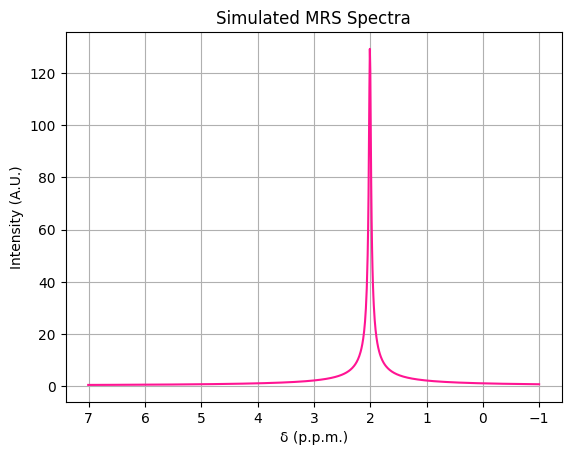

In [4]:
pymri.plot_chem_shifts(freqs, sig_fft, 1.0)

In [5]:
L = 0.4
noise_threshold = 1e-30
rcond=noise_threshold
L_ = int(L*sig.size)

In [6]:
size = 20
# offsets = 10**(-(np.linspace(-3, size - 3 - 1, size)))
offsets = np.array([100.0, 10.0, 7.5, 5.0, 2.5, 1.0, 0.75, 0.5, 0.25, 0.1])
print(offsets)

offset = 10.0

sample_snrs = np.array([0.25, 0.50, 0.75, 1.0, 2.5, 5.0, 10.0, 25.0, 50.0, 75.0, 100.0])


[100.    10.     7.5    5.     2.5    1.     0.75   0.5    0.25   0.1 ]


In [7]:
L_ = int(L*2048)
shape = (sample_snrs.size, offsets.size, L_)
s0s_, phis_, omegas_, t2s_ = np.zeros(shape), np.zeros(shape), np.zeros(shape), np.zeros(shape)
original_c_sigs = np.zeros((sample_snrs.size, offsets.size, 2048), dtype=np.complex128)

In [8]:
filename_end = "_offsets"
folder_name = "files/"
subfolder_name = "two_peaks_noisy/"

In [9]:

s0s_            = np.load(folder_name + subfolder_name + "s0s_" + filename_end + ".npy")
phis_           = np.load(folder_name + subfolder_name + "phis_" + filename_end + ".npy")
omegas_         = np.load(folder_name + subfolder_name + "omegas_" + filename_end + ".npy")
t2s_            = np.load(folder_name + subfolder_name + "t2s_" + filename_end + ".npy")
original_c_sigs = np.load(folder_name + subfolder_name + "original_c_sigs" + filename_end + ".npy")


In [10]:
args = np.argsort(s0s_, axis=2)
print(args.shape)

(11, 10, 819)


In [59]:
i_ = 5
j_ = 0

# identified_t2 = t2s_[i_, j_, args[i_, j_, :]]
# identified_s0 = s0s_[i_, j_, args[i_, j_, :]]
# identified_omega = omegas_[i_, j_, args[i_, j_, :]]
# identified_phi = phis_[i_, j_, args[i_, j_, :]]
identified_t2 = t2s_[i_, j_, :]
identified_s0 = s0s_[i_, j_, :]
identified_omega = omegas_[i_, j_, :]
identified_phi = phis_[i_, j_, :]



print(f"SNR {sample_snrs[i_]} e offset {offsets[j_]}")

SNR 5.0 e offset 100.0


In [60]:
lower_order = -1.3
higher_order = -0.5

In [61]:
lower_order_arr = np.log10(np.abs(identified_t2)) <= lower_order
higher_order_arr = np.log10(np.abs(identified_t2)) > higher_order
negative_arr = identified_t2 <= 0.0
t2_filter_arr = np.bitwise_and( np.bitwise_and( np.bitwise_not(lower_order_arr), np.bitwise_not(higher_order_arr) ), np.bitwise_not(negative_arr))

print("T2")
print(f"Ordem absoluta menor que {lower_order}\t : {identified_t2[lower_order_arr].size}")
print(f"Ordem absoluta maior que {higher_order}\t : {identified_t2[higher_order_arr].size}")
print(f"Negativos\t\t\t: {identified_t2[negative_arr].size}")
print(f"Restantes\t\t\t: {identified_t2[t2_filter_arr].size}")

T2
Ordem absoluta menor que -1.3	 : 43
Ordem absoluta maior que -0.5	 : 478
Negativos			: 82
Restantes			: 294


## Variância de $T_2$

Acredito que vale a pena fazer um estudo da variância dos valores de t2 calculados pelo algoritmo com relação aos t2s originais para ver se ocorre distorção muito grande. Se, em teoria, a área do sinal deve se conservar, a variação do t2 em um lado significa a variação da frequência em outro?

## Frequências impossíveis

In [62]:
limit_omega = pymri.max_frequency(dt)
print(limit_omega)

1024.0


In [63]:
possible_omegas_arr = pymri.rad_to_hz(identified_omega) <= limit_omega

print(identified_omega[possible_omegas_arr].size)

409


In [64]:
filter_arr = np.bitwise_and(t2_filter_arr, possible_omegas_arr)

print(identified_omega[filter_arr].size)

141


## Filtro?

In [65]:
t2_filtered_s0 = identified_s0[t2_filter_arr]
t2_filtered_omega = identified_omega[t2_filter_arr]
t2_filtered_phi = identified_phi[t2_filter_arr]
t2_filtered_t2 = identified_t2[t2_filter_arr]

In [66]:
t2_filtered_pop = pymri.population(t2_filtered_omega, t2_filtered_t2, t2_filtered_s0, t2_filtered_phi)

t2_filtered_sig, t = pymri.population_transverse_decay( t0, tn, dt, t2_filtered_pop)
_, t2_filtered_sig_fft = pymri.fourier_spectrum(t2_filtered_sig, dt, B0)


In [67]:
ws[1] = ws[0] + offsets[j_]
print(ws)
pop = pymri.population(ws, t2s, M_0s, spins_phi)
sig, t = pymri.population_transverse_decay( t0, tn, dt, pop, np.array([]) )
freqs, sig_fft = pymri.fourier_spectrum( sig, dt, B0 )
sig_fft = sig_fft/np.nanmax(sig_fft)

[2411.71251655 2511.71251655]


([], [])

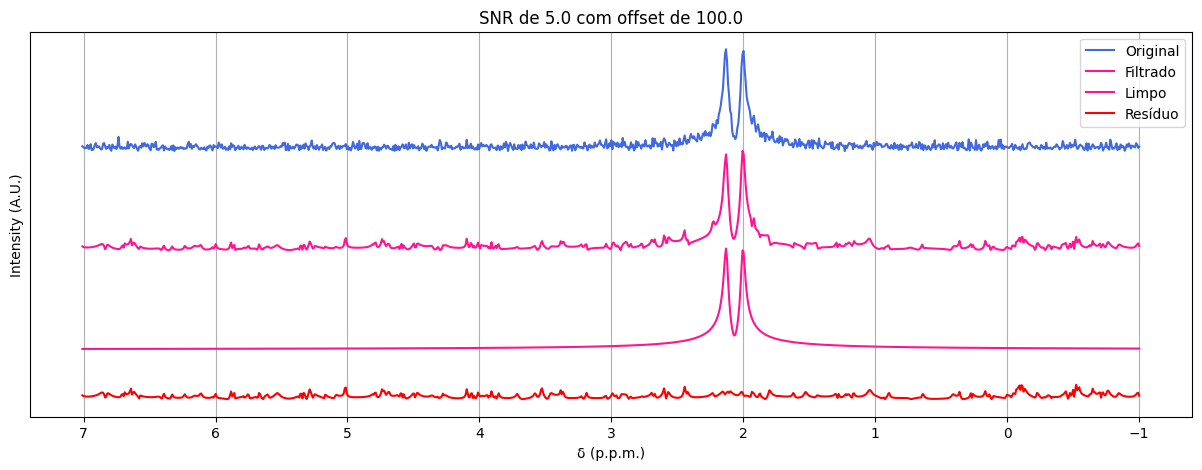

In [68]:
_, c_sig_fft = pymri.fourier_spectrum(original_c_sigs[i_, j_, :], dt, B0)

y_offset = 1.0

plt.figure(figsize=(15, 5))
pymri.plot_chem_shifts(freqs, c_sig_fft, y_offset=3*y_offset, label="Original", c = "royalblue")
pymri.plot_chem_shifts(freqs, t2_filtered_sig_fft, y_offset=2*y_offset, label="Filtrado")
pymri.plot_chem_shifts(freqs, sig_fft, y_offset=1*y_offset, label="Limpo")
pymri.plot_chem_shifts(freqs, sig_fft - t2_filtered_sig_fft, y_offset=0.5*y_offset, label="Resíduo", c = "red", title=f"SNR de {sample_snrs[i_]} com offset de {offsets[j_]}")
plt.legend()
plt.yticks([])

In [82]:
# print(t2_filtered_s0.shape)

s0_args = np.argsort(t2_filtered_s0)

# print(s0_args.shape)
t2_L = s0_args.size

k = 3

print(t2_filtered_s0[s0_args][t2_L-k:t2_L])
print(t2_filtered_omega[s0_args][t2_L-k:t2_L])
print(t2_filtered_t2[s0_args][t2_L-k:t2_L])

[0.00284621 0.00456483 0.00620425]
[12015.87341482  2512.23423335  2411.63262922]
[0.05438412 0.10215154 0.0776944 ]


In [70]:
s0_filtered_s0 = t2_filtered_s0[s0_args][t2_L - 2: t2_L]
s0_filtered_omega = t2_filtered_omega[s0_args][t2_L - 2: t2_L]
s0_filtered_phi = t2_filtered_phi[s0_args][t2_L - 2: t2_L]
s0_filtered_t2 = t2_filtered_t2[s0_args][t2_L - 2: t2_L]

In [71]:
s0_filtered_pop = pymri.population(s0_filtered_omega, s0_filtered_t2, s0_filtered_s0, s0_filtered_phi)

s0_filtered_sig, t = pymri.population_transverse_decay( t0, tn, dt, s0_filtered_pop)
_, s0_filtered_sig_fft = pymri.fourier_spectrum(s0_filtered_sig, dt, B0)

([], [])

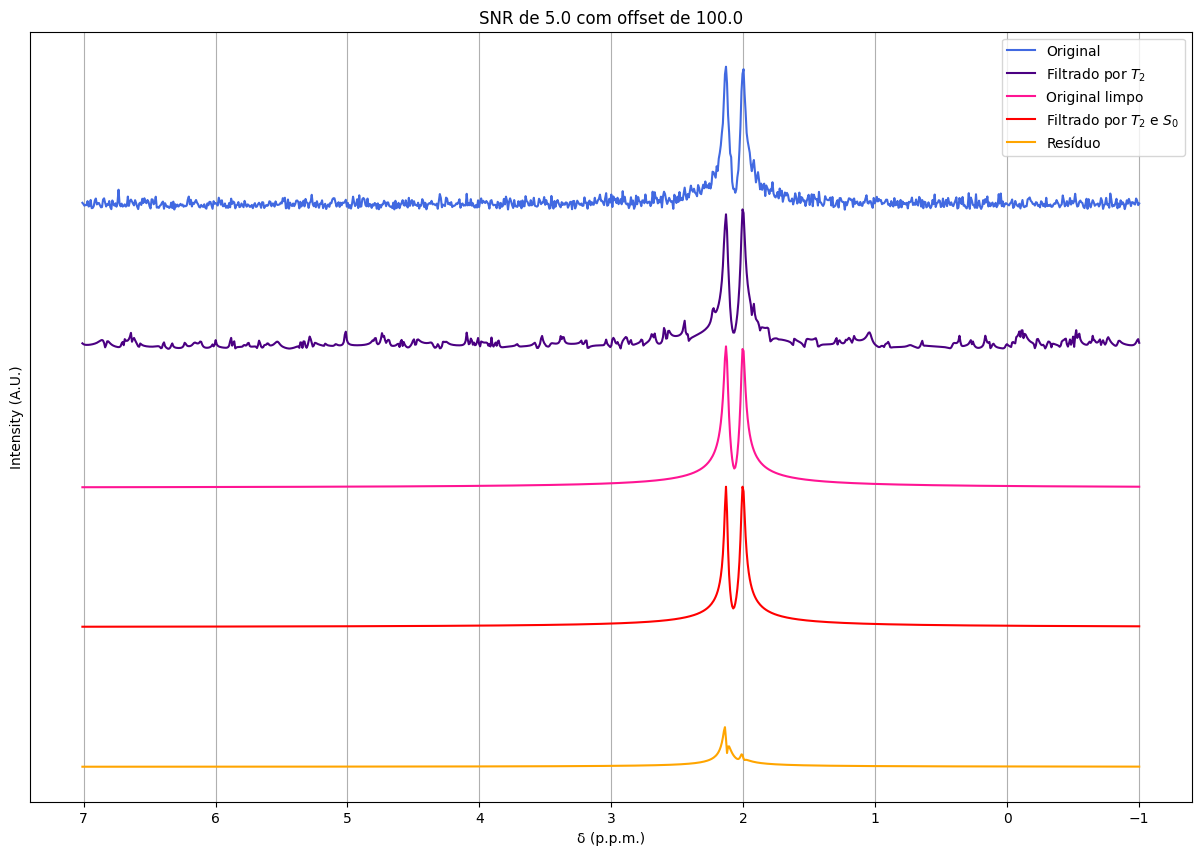

In [80]:
_, c_sig_fft = pymri.fourier_spectrum(original_c_sigs[i_, j_, :], dt, B0)

y_offset = 1.0

plt.figure(figsize=(15, 10))
pymri.plot_chem_shifts(freqs, c_sig_fft, y_offset=3*y_offset, label="Original", c = "royalblue")
pymri.plot_chem_shifts(freqs, t2_filtered_sig_fft, y_offset=2*y_offset, label=r"Filtrado por $T_2$", c = "indigo")
pymri.plot_chem_shifts(freqs, sig_fft, y_offset=1*y_offset, label="Original limpo")
pymri.plot_chem_shifts(freqs, s0_filtered_sig_fft, y_offset=0.0*y_offset, label=r"Filtrado por $T_2$ e $S_0$", c = "red")
pymri.plot_chem_shifts(freqs, sig_fft - s0_filtered_sig_fft, y_offset=-1*y_offset, label="Resíduo", c = "orange", title=f"SNR de {sample_snrs[i_]} com offset de {offsets[j_]}")
plt.legend()
plt.yticks([])